In [319]:
%load_ext autoreload
%autoreload 2
%cd ..
import numpy as np
import matplotlib.pyplot as plt
from src.ortools_solver import CVRP_solver
from src.utils import distance_calculator, calculate_distance_matrix, show_matrix, print_command, calculate_num_rows
import pygmtools as pygm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/yq-mew/yq/chem1906


In [320]:
def calculate_S_E(a, P=None):
    # a the jobs matrix, row is the source, column is the destination
    if P is not None:
        a = np.dot(a, P)
    a[a>0] = 1
    jobs = np.argwhere(a)
    starting_point = np.zeros((jobs.shape[0], a.shape[0]))
    ending_point = np.zeros((jobs.shape[0], a.shape[1]))
    ending_map = dict(np.argwhere(P if P is not None else np.eye(a.shape[1])).tolist())
    new_jobs = []
    for i in range(jobs.shape[0]):
        starting_point[i, jobs[i, 0]] = 1
        ending_point[i, ending_map[jobs[i, 1]]] = 1
        new_jobs.append([jobs[i, 0], ending_map[jobs[i, 1]]])
    if P is None:
        return starting_point, ending_point
    else:
        return starting_point, ending_point, np.array(new_jobs)

def calculate_D_prime(D_S, D_D, S, E):
    # calculate D' = S(D_S)S^T + E(D_D)E^T
    D_prime = np.dot(np.dot(S, D_S), S.T) + np.dot(np.dot(E, D_D), E.T)
    return D_prime

def add_depot(D_prime):
    # add a depot to D'
    D_prime = np.vstack((np.zeros(D_prime.shape[0]), D_prime))
    D_prime = np.hstack((np.zeros((D_prime.shape[0], 1)), D_prime))
    return D_prime

def get_optimized_sequence(recorder):
    # get the optimized sequences from the VCRP solver, pad with -1 and sort
    for i in range(len(recorder)):
        recorder[i] = np.array(recorder[i])
        recorder[i] = np.pad(recorder[i], (0, 8-recorder[i].shape[0]), 'constant', constant_values=-1)
    # move the elements containing -1 to the end
    optimized_seuqnece = np.array(recorder)
    optimized_seuqnece = np.array(sorted(optimized_seuqnece, key=lambda x: np.sum(x!=-1)))
    optimized_seuqneces = np.array(optimized_seuqnece[::-1])
    return optimized_seuqneces

def calculate_T(sequences):
    # the matrix should be paddled with -1, return a n*n matrix
    # sequences is a n*8 matrix

    sequences_flat = sequences.flatten()
    sequences_flat = sequences_flat[sequences_flat != -1]
    zeros = np.zeros((sequences_flat.shape[0],sequences_flat.shape[0]))
    for sequence in sequences:
        for i in range(sequence.shape[0]-1):
            if sequence[i] != -1 and sequence[i+1] != -1:
                zeros[sequence[i]-1,sequence[i+1]-1] = 1
            else:
                break
    return zeros

In [321]:
def calculate_D(labware:int):
    num_rows = calculate_num_rows(labware)
    D = np.ones((labware,labware))
    for i in range(labware):
        for j in range(labware):
            if i//num_rows == j//num_rows:
                if i-j == -1:
                    D[i, j] = 0

    if labware == 384:
        D = np.ones((labware,labware))
        for i in range(labware):
            for j in range(labware):
                if i//num_rows == j//num_rows:
                    if i-j == -2:
                        D[i, j] = 0
    elif labware == 1536:
        D = np.ones((labware,labware))
        for i in range(labware):
            for j in range(labware):
                if i//num_rows == j//num_rows:
                    if i-j == -4:
                        D[i, j] = 0
    return D

In [322]:
def calculate_T(sequences):
    # the matrix should be paddled with -1, return a n*n matrix
    # sequences is a n*8 matrix

    sequences_flat = sequences.flatten()
    sequences_flat = sequences_flat[sequences_flat != -1]
    zeros = np.zeros((sequences_flat.shape[0],sequences_flat.shape[0]))
    for sequence in sequences:
        for i in range(sequence.shape[0]-1):
            if sequence[i] != -1 and sequence[i+1] != -1:
                zeros[sequence[i]-1,sequence[i+1]-1] = 1
            else:
                break
    return zeros

def calculate_cost(task_matrix):
    # T is a n*n matrix
    # D_prime is a (n+1)*(n+1) matrix with the zero paddle
    # return the cost of the T and D_prime
    jobs = np.argwhere(task_matrix)
    D_S = calculate_D(task_matrix.shape[0])
    D_D = calculate_D(task_matrix.shape[1])   
    S, E = calculate_S_E(task_matrix)
    D_prime = calculate_D_prime(D_S,D_D, S, E)
    
    t = calculate_T(jobs)
    # cost = trace (T^T * D_prime)
    cost = np.trace(np.dot(t.T, D_prime))
    return cost

In [323]:
def CVRP_QAP(task_matrix, iteration=5, inner_cvrp_timewall=2, final_cvrp_timewall=10, ipfp_maxiter=50):
    task_matrix[task_matrix>0] = 1
    jobs = np.argwhere(task_matrix)
    D_S = calculate_D(task_matrix.shape[0])
    D_D = calculate_D(task_matrix.shape[1])   

    output_P = np.eye(task_matrix.shape[1])
    S, E = calculate_S_E(task_matrix)
    D_prime = calculate_D_prime(D_S,D_D, S, E)
    best_cost = float('inf')
    for i in range(iteration):
        # construct & update CVRP
        D_prime = add_depot(D_prime)

        # solve CVRP
        optimized_distance, recorder = CVRP_solver(D_prime.astype(np.int64), solving_time=inner_cvrp_timewall)

        optimized_seuqnecess = get_optimized_sequence(recorder)
        t = calculate_T(optimized_seuqnecess)
        D_prime = D_prime[1:, 1:]
        # cost = trace (T^T * D_prime)
        cost = np.trace(np.dot(t.T, D_prime))
        print(f'iter={i}, cost={cost} after CVRP')
        if best_cost > cost:
            best_cost = cost
            best_output_P = output_P

        # construct QAP
        A = np.dot(np.dot(E.T, t.T), E)
        B = D_D
        K = np.kron(1-B, A.T) # transform minimization into maximization

        # solve QAP
        P = pygm.ipfp((K + K.T), n1=task_matrix.shape[1], n2=task_matrix.shape[1], x0=np.eye(task_matrix.shape[1])[None,:,:], max_iter=ipfp_maxiter)

        # new_E = E * P
        new_E = np.dot(E, P)
        new_D_prime = calculate_D_prime(D_S,D_D, S, new_E)
        cost = np.trace(np.dot(t.T, new_D_prime))
        output_P = np.dot(output_P, P)
        print(f'iter={i}, cost={cost} after QAP')
        if best_cost > cost:
            best_cost = cost
            best_output_P = output_P

        # update params
        D_prime = new_D_prime
        E = new_E

    # calculate best CVRP result with more solving time
    S, E, new_jobs = calculate_S_E(task_matrix, best_output_P)
    D_prime = calculate_D_prime(D_S,D_D, S, E)
    D_prime = np.vstack((np.zeros(D_prime.shape[0]), D_prime))
    D_prime = np.hstack((np.zeros((D_prime.shape[0], 1)), D_prime))
    best_cost, best_recorder = CVRP_solver(D_prime.astype(np.int64), solving_time=final_cvrp_timewall)
    print(f'solution cost={best_cost}')

    # transform to job id sequence
    best_recorder = get_optimized_sequence(best_recorder)

    return best_cost, best_output_P, new_jobs, best_recorder

In [324]:
def random_choice(total_elements, chosen_elements):
    '''
    total_elements: total number of elements in the array
    chosen_elements: number of elements to be chosen
    '''
    a = np.zeros(total_elements)
    random_vector = np.random.rand(chosen_elements)
    random_vector = random_vector.round(2)
    random_vector = random_vector / random_vector.sum(axis=0, keepdims=1)
    a[:chosen_elements] = random_vector
    np.random.shuffle(a)
    return a

def random_choose_candidate(source_dim,dest_dim,non_zeros_dim): 
    '''
    num_candidate: number of candidate to be chosen
    total_candidate: total number of candidates
    chosen_elements: number of elements to be chosen
    '''
    # repeat the random_choice function for num_candidate times
    a = np.zeros((source_dim,dest_dim))
    for i in range(source_dim):
        candidate = random_choice(dest_dim,non_zeros_dim)
        a[i,:] = candidate
    return a.round(2)

In [7]:
labware_list =[12,24,96,384]
# enumerate all the two combinations of the labware_list
labware_combinations = []
for i in range(len(labware_list)):
    for j in range(len(labware_list)):
        labware_combinations.append([labware_list[i], labware_list[j]])
labware_combinations

[[12, 12],
 [12, 24],
 [12, 96],
 [12, 384],
 [24, 12],
 [24, 24],
 [24, 96],
 [24, 384],
 [96, 12],
 [96, 24],
 [96, 96],
 [96, 384],
 [384, 12],
 [384, 24],
 [384, 96],
 [384, 384]]

In [ ]:
# Just VRP
stats = []
for labware_combination in labware_combinations:
        print(f'labware_combination: {labware_combination}')
        np.random.seed(0)
        for r in range (1):
            print('repeat:',r)
            stat = []
            for i in range(1,10):
                print(f'num_candidates={i}')
                experiments = random_choose_candidate(labware_combination[0],labware_combination[1],i)
                jobs = np.argwhere(experiments)
                D_S = calculate_D(experiments.shape[0])
                D_D = calculate_D(experiments.shape[1])
                S, E = calculate_S_E(experiments)   
                # calculate distance matrix
                D_prime = calculate_D_prime(D_S,D_D, S, E)
                D_prime = add_depot(D_prime)
                optimized_distance = 0
                VRP_distance, _ = CVRP_solver(D_prime.astype(np.int64), solving_time =20)
                non_optimized_distance = distance_calculator(jobs)
                stat.append((i,non_optimized_distance,optimized_distance, VRP_distance))
            stat = np.array(stat)
            stats.append(stat)
        stats = np.array(stats)
        # save the stats
        stats.to_csv(f'stats_{labware_combination[0]}_{labware_combination[1]}.csv', index=False)

labware_combination: [12, 12]
repeat: 0
num_candidates=1
num_candidates=2


In [ ]:
def row_wise_optimization(index_matrix):
    """
    Perform row‐wise, round‐robin picking of non‐zero entries in `index_matrix`
    with a slight preference for items adjacent (in the same 8‐wide block)
    to the last picked column.

    Args:
        index_matrix (np.ndarray): 2D array where non‐zero entries are job IDs.

    Returns:
        np.ndarray: 1D array of job IDs in the pick order.
    """

    
    # Work on a copy so we don't destroy the caller's matrix
    mat = index_matrix.copy()
    seq = []
    last_col = 0
    count = 0
    n_rows = mat.shape[0]

    # Continue until we've zeroed out every job
    while mat.sum() != 0:
        row_num = count % n_rows
        row = mat[row_num]
        non_zeros = np.argwhere(row).flatten()

        if non_zeros.size > 0:
            # pick one at random
            col = np.random.choice(non_zeros)
            # but if any non-zero is immediately to the right of last_col
            # within the same block of width 8, prefer that one
            for j in non_zeros:
                if (j - last_col) == 1 and (j // 8) == (last_col // 8):
                    col = j
                    break

            # record and remove it
            seq.append(mat[row_num, col])
            mat[row_num, col] = 0
            last_col = col
            count += 1
        else:
            count += 1
            continue

    return np.array(seq, dtype=int)

In [310]:
def greedy_scheduling(jobs, d):
    """
    Build a greedy sequence of job indices by always moving
    to the (closest) unvisited job according to the distance matrix.

    Args:
        jobs (array-like): list/array of jobs (only used for its length).
        d (2D array-like): square distance matrix of shape (n_jobs, n_jobs),
                           where d[i, j] is the “distance” from job i to job j.
                            no depot!!

    Returns:
        np.ndarray: 1D array of job indices in the order they were visited.
    """
    jobs_idx = np.array(range(jobs.shape[0]))
    # randomly choose an idx as the start point
    start_idx = np.random.choice(jobs_idx)
    # remove the start_idx from the jobs_idx
    jobs_idx = np.delete(jobs_idx, np.where(jobs_idx == start_idx))
    greedy_sequence = [start_idx]
    count = 0
    while jobs_idx.shape[0] != 0:
        count += 1
        # find the minimum distance in the distance matrix of row start_idx
        min_idx = np.where(d[start_idx] == d[start_idx].min())[0]
        # randomly choose one of the minimum distance
        # check if the min_idx is in the jobs_idx
        min_idx = np.intersect1d(min_idx, jobs_idx)
        if min_idx.shape[0] == 0:
            rand_min_idx = np.random.choice(jobs_idx)
        else:
            rand_min_idx = np.random.choice(min_idx)
        start_idx = rand_min_idx
        if count%8 == 7:
            start_idx = np.random.choice(jobs_idx)
        # remove the rand_min_idx from the jobs_idx
        jobs_idx = np.delete(jobs_idx, np.where(jobs_idx == start_idx))

        
        
        greedy_sequence.append(start_idx)
    greedy_sequence = np.array(greedy_sequence)
    return greedy_sequence

In [183]:
def random_choose_candidate_2(source_dim,dest_dim,non_zeros_num):
    '''
    num_candidate: number of candidate to be chosen
    total_candidate: total number of candidates
    chosen_elements: number of elements to be chosen
    '''
    non_zeros =0
    # repeat the random_choice function for num_candidate times
    a = np.zeros((source_dim,dest_dim))
    # randomly choose non_zeros_dim elements in the matrix as 1
    for i in range(source_dim):
        for j in range(dest_dim):
            if np.random.rand() >(1-non_zeros_num/(source_dim*dest_dim)):
                a[i,j] = 1
                non_zeros += 1
            if non_zeros >= non_zeros_num:
                break
    return a

In [311]:
stats = []
source_dim = 96
dest_dim = 96
a = random_choose_candidate_2(source_dim,dest_dim,500)
a[a>0] = 1
jobs = np.argwhere(a)
D_S = calculate_D(a.shape[0])
D_D = calculate_D(a.shape[1])
S, E = calculate_S_E(a)   
# calculate distance matrix
D_prime = calculate_D_prime(D_S,D_D, S, E)
D_prime = add_depot(D_prime)
# VRP solver
VRP_distance, VRP_recorder = CVRP_solver(D_prime.astype(np.int64), solving_time =20)
print(f'VRP_distance: {VRP_distance}')
# calculate the cost of the non-optimized sequence
tasks = np.array(range(jobs.shape[0]))
tasks = tasks+1
# if tasks.shape[0] %8 != 0, pad with -1
if tasks.shape[0] %8 != 0:
    tasks = np.pad(tasks, (0, 8-tasks.shape[0]%8), 'constant', constant_values=-1)
unoptimized_seuqnece = tasks.reshape(-1, 8)
t = calculate_T(unoptimized_seuqnece)
d = D_prime[1:, 1:]
non_optimized_distance = np.trace(np.dot(t.T, d))
# change non_optimized_distance to integer
non_optimized_distance = int(non_optimized_distance)
print(f'non_optimized_distance: {non_optimized_distance}')
# calculate the cost of the row-wise optimized sequence
index_matrix = np.zeros((source_dim,dest_dim))
for i in range(jobs.shape[0]):
    index_matrix[jobs[i, 0], jobs[i, 1]] = i+1
row_wise_optimized_sequence = row_wise_optimization(index_matrix)
if row_wise_optimized_sequence.shape[0] %8 != 0:
    row_wise_optimized_sequence = np.pad(row_wise_optimized_sequence, (0, 8-row_wise_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
row_wise_optimized_sequence = row_wise_optimized_sequence.reshape(-1, 8)
t = calculate_T(row_wise_optimized_sequence)
row_wise_optimized_distance = np.trace(np.dot(t.T, d))
# change non_optimized_distance to integer
row_wise_optimized_distance = int(row_wise_optimized_distance)
print(f'row_wise_optimized_distance: {row_wise_optimized_distance}')

# calculate the cost of the greedy optimized sequence
greedy_optimized_sequence = greedy_scheduling(jobs, d)
if greedy_optimized_sequence.shape[0] %8 != 0:
    greedy_optimized_sequence = np.pad(greedy_optimized_sequence, (0, 8-greedy_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
greedy_optimized_sequence = greedy_optimized_sequence.reshape(-1, 8)
t = calculate_T(greedy_optimized_sequence)
greedy_optimized_distance = np.trace(np.dot(t.T, d))
print(f'greedy_optimized_distance: {greedy_optimized_distance}')


VRP_distance: 452
non_optimized_distance: 780
row_wise_optimized_distance: 556
greedy_optimized_distance: 752.0


In [314]:
stats = []
source_dim = 384
dest_dim = 384
for i in range(100, 2400, 200):
    print(f'num_candidates={i}')
    a = random_choose_candidate_2(source_dim,dest_dim,i)
    a[a>0] = 1
    jobs = np.argwhere(a)
    D_S = calculate_D(a.shape[0])
    D_D = calculate_D(a.shape[1])
    S, E = calculate_S_E(a)   
    # calculate distance matrix
    D_prime = calculate_D_prime(D_S,D_D, S, E)
    D_prime = add_depot(D_prime)
    # VRP solver
    VRP_distance, VRP_recorder = CVRP_solver(D_prime.astype(np.int64), solving_time =20)
    print(f'VRP_distance: {VRP_distance}')
    # calculate the cost of the non-optimized sequence
    tasks = np.array(range(jobs.shape[0]))
    tasks = tasks+1
    # if tasks.shape[0] %8 != 0, pad with -1
    if tasks.shape[0] %8 != 0:
        tasks = np.pad(tasks, (0, 8-tasks.shape[0]%8), 'constant', constant_values=-1)
    unoptimized_seuqnece = tasks.reshape(-1, 8)
    t = calculate_T(unoptimized_seuqnece)
    d = D_prime[1:, 1:]
    non_optimized_distance = np.trace(np.dot(t.T, d))
    # change non_optimized_distance to integer
    non_optimized_distance = int(non_optimized_distance)
    print(f'non_optimized_distance: {non_optimized_distance}')
    # calculate the cost of the row-wise optimized sequence
    index_matrix = np.zeros((source_dim,dest_dim))
    for i in range(jobs.shape[0]):
        index_matrix[jobs[i, 0], jobs[i, 1]] = i+1
    row_wise_optimized_sequence = row_wise_optimization(index_matrix)
    if row_wise_optimized_sequence.shape[0] %8 != 0:
        row_wise_optimized_sequence = np.pad(row_wise_optimized_sequence, (0, 8-row_wise_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
    row_wise_optimized_sequence = row_wise_optimized_sequence.reshape(-1, 8)
    t = calculate_T(row_wise_optimized_sequence)
    row_wise_optimized_distance = np.trace(np.dot(t.T, d))
    # change non_optimized_distance to integer
    row_wise_optimized_distance = int(row_wise_optimized_distance)
    print(f'row_wise_optimized_distance: {row_wise_optimized_distance}')

    # calculate the cost of the greedy optimized sequence
    greedy_optimized_sequence = greedy_scheduling(jobs, d)
    if greedy_optimized_sequence.shape[0] %8 != 0:
        greedy_optimized_sequence = np.pad(greedy_optimized_sequence, (0, 8-greedy_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
    greedy_optimized_sequence = greedy_optimized_sequence.reshape(-1, 8)
    t = calculate_T(greedy_optimized_sequence)
    greedy_optimized_distance = np.trace(np.dot(t.T, d))
    print(f'greedy_optimized_distance: {greedy_optimized_distance}')
    stats.append((i,non_optimized_distance,VRP_distance,row_wise_optimized_distance,greedy_optimized_distance))
stats = np.array(stats)

num_candidates=100
VRP_distance: 144
non_optimized_distance: 163
row_wise_optimized_distance: 162
greedy_optimized_distance: 173.0
num_candidates=300
VRP_distance: 362
non_optimized_distance: 487
row_wise_optimized_distance: 478
greedy_optimized_distance: 507.0
num_candidates=500
VRP_distance: 570
non_optimized_distance: 812
row_wise_optimized_distance: 779
greedy_optimized_distance: 813.0
num_candidates=700
VRP_distance: 743
non_optimized_distance: 1169
row_wise_optimized_distance: 1118
greedy_optimized_distance: 1122.0
num_candidates=900
VRP_distance: 961
non_optimized_distance: 1545
row_wise_optimized_distance: 1479
greedy_optimized_distance: 1469.0
num_candidates=1100
VRP_distance: 1130
non_optimized_distance: 1909
row_wise_optimized_distance: 1821
greedy_optimized_distance: 1740.0
num_candidates=1300
VRP_distance: 1309
non_optimized_distance: 2218
row_wise_optimized_distance: 2089
greedy_optimized_distance: 2037.0
num_candidates=1500
VRP_distance: 1511
non_optimized_distance: 2607

In [325]:
stats = []
source_dim = 1536
dest_dim = 1536
for i in range(100, 2400, 200):
    print(f'num_candidates={i}')
    a = random_choose_candidate_2(source_dim,dest_dim,i)
    a[a>0] = 1
    jobs = np.argwhere(a)
    D_S = calculate_D(a.shape[0])
    D_D = calculate_D(a.shape[1])
    S, E = calculate_S_E(a)   
    # calculate distance matrix
    D_prime = calculate_D_prime(D_S,D_D, S, E)
    D_prime = add_depot(D_prime)
    # VRP solver
    VRP_distance, VRP_recorder = CVRP_solver(D_prime.astype(np.int64), solving_time =20)
    print(f'VRP_distance: {VRP_distance}')
    # calculate the cost of the non-optimized sequence
    tasks = np.array(range(jobs.shape[0]))
    tasks = tasks+1
    # if tasks.shape[0] %8 != 0, pad with -1
    if tasks.shape[0] %8 != 0:
        tasks = np.pad(tasks, (0, 8-tasks.shape[0]%8), 'constant', constant_values=-1)
    unoptimized_seuqnece = tasks.reshape(-1, 8)
    t = calculate_T(unoptimized_seuqnece)
    d = D_prime[1:, 1:]
    non_optimized_distance = np.trace(np.dot(t.T, d))
    # change non_optimized_distance to integer
    non_optimized_distance = int(non_optimized_distance)
    print(f'non_optimized_distance: {non_optimized_distance}')
    # calculate the cost of the row-wise optimized sequence
    index_matrix = np.zeros((source_dim,dest_dim))
    for i in range(jobs.shape[0]):
        index_matrix[jobs[i, 0], jobs[i, 1]] = i+1
    row_wise_optimized_sequence = row_wise_optimization(index_matrix)
    if row_wise_optimized_sequence.shape[0] %8 != 0:
        row_wise_optimized_sequence = np.pad(row_wise_optimized_sequence, (0, 8-row_wise_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
    row_wise_optimized_sequence = row_wise_optimized_sequence.reshape(-1, 8)
    t = calculate_T(row_wise_optimized_sequence)
    row_wise_optimized_distance = np.trace(np.dot(t.T, d))
    # change non_optimized_distance to integer
    row_wise_optimized_distance = int(row_wise_optimized_distance)
    print(f'row_wise_optimized_distance: {row_wise_optimized_distance}')

    # calculate the cost of the greedy optimized sequence
    greedy_optimized_sequence = greedy_scheduling(jobs, d)
    if greedy_optimized_sequence.shape[0] %8 != 0:
        greedy_optimized_sequence = np.pad(greedy_optimized_sequence, (0, 8-greedy_optimized_sequence.shape[0]%8), 'constant', constant_values=-1)
    greedy_optimized_sequence = greedy_optimized_sequence.reshape(-1, 8)
    t = calculate_T(greedy_optimized_sequence)
    greedy_optimized_distance = np.trace(np.dot(t.T, d))
    print(f'greedy_optimized_distance: {greedy_optimized_distance}')
    stats.append((i,non_optimized_distance,VRP_distance,row_wise_optimized_distance,greedy_optimized_distance))
stats = np.array(stats)

num_candidates=100
VRP_distance: 166
non_optimized_distance: 170
row_wise_optimized_distance: 170
greedy_optimized_distance: 173.0
num_candidates=300
VRP_distance: 399
non_optimized_distance: 446
row_wise_optimized_distance: 442
greedy_optimized_distance: 460.0
num_candidates=500
VRP_distance: 690
non_optimized_distance: 837
row_wise_optimized_distance: 834
greedy_optimized_distance: 867.0
num_candidates=700
VRP_distance: 908
non_optimized_distance: 1105
row_wise_optimized_distance: 1099
greedy_optimized_distance: 1136.0
num_candidates=900
VRP_distance: 1140
non_optimized_distance: 1513
row_wise_optimized_distance: 1509
greedy_optimized_distance: 1507.0
num_candidates=1100
VRP_distance: 1393
non_optimized_distance: 1885
row_wise_optimized_distance: 1867
greedy_optimized_distance: 1882.0
num_candidates=1300
VRP_distance: 1555
non_optimized_distance: 2164
row_wise_optimized_distance: 2143
greedy_optimized_distance: 2150.0
num_candidates=1500
VRP_distance: 1816
non_optimized_distance: 259

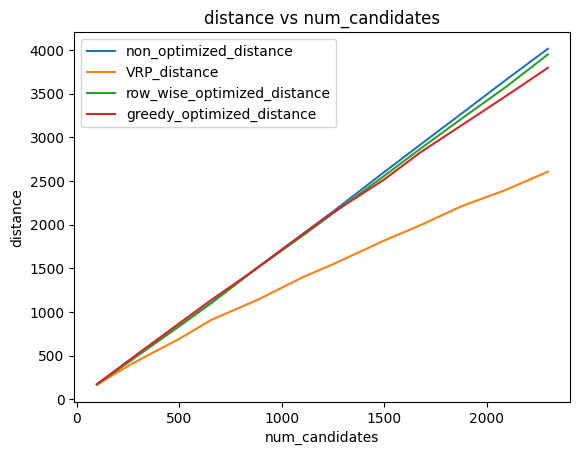

In [326]:
# plot the stats
plt.plot(stats[:,0], stats[:,1], label='non_optimized_distance')
plt.plot(stats[:,0], stats[:,2], label='VRP_distance')
plt.plot(stats[:,0], stats[:,3], label='row_wise_optimized_distance')
plt.plot(stats[:,0], stats[:,4], label='greedy_optimized_distance')
plt.xlabel('num_candidates')
plt.ylabel('distance')
plt.title('distance vs num_candidates')
plt.legend()
plt.show()

In [211]:
a = a2
# binarize the matrix
a[a>0] = 1
jobs = np.argwhere(a)
D_S = calculate_D(a.shape[0])
D_D = calculate_D(a.shape[1])
S, E = calculate_S_E(a)   
# calculate distance matrix
D_prime = calculate_D_prime(D_S,D_D, S, E)

In [297]:
index_matrix = np.zeros((96,96))
for i in range(jobs.shape[0]):
    index_matrix[jobs[i, 0], jobs[i, 1]] = i+1

In [214]:
sequence = []
last_column = 0
count = 0
while np.sum(index_matrix) != 0:
    row_num = count % 96
    # randomly choose a non-zero element in the row of index_matrix
    if np.sum(index_matrix[row_num]) != 0:
        non_zeros = np.argwhere(index_matrix[row_num]).flatten()
        col_num = np.random.choice(non_zeros)
        # check if there are any non-zero that are next to last_column
        for j in non_zeros:
            if (j-last_column)==1 and j//8 == last_column//8:
                col_num = j

        sequence.append(index_matrix[row_num, col_num])
        index_matrix[row_num, col_num] = 0
        last_column = col_num
        count += 1
    else:
        count += 1
        continue
sequence = np.array(sequence,dtype=int)

In [215]:
sequence

array([  1,   7,  10,  16,  19,  24,  29,  36,  39,  45,  56,  58,  63,
        69,  73,  78,  82,  87,  89,  91,  96, 100, 105, 111, 116, 122,
       131, 135, 141, 146, 154, 156, 161, 164, 170, 172, 181, 184, 190,
       192, 196, 202, 208, 217, 223, 228, 232, 235, 242, 250, 255, 258,
       265, 269, 277, 278, 289, 291, 296, 303, 315, 316, 319, 325, 329,
       341, 353, 360, 365, 372, 375, 378, 380, 385, 394, 401, 403, 409,
       414, 421, 427, 431, 437, 446, 451, 454, 459, 461, 466, 469, 472,
       476, 481, 486, 495,   2,   5,  12,  14,  18,  28,  32,  38,  41,
        49,  52,  64,  71,  72,  75,  85,  86,  88,  92,  98, 102, 110,
       115, 123, 129, 138, 143, 150, 152, 157, 160, 162, 168, 176, 180,
       183, 185, 191, 199, 204, 210, 216, 225, 230, 233, 238, 244, 251,
       256, 260, 266, 273, 279, 286, 290, 293, 300, 310, 317, 321, 326,
       339, 340, 346, 356, 367, 370, 376, 377, 381, 387, 398, 399, 404,
       410, 419, 422, 429, 433, 434, 447, 450, 453, 460, 463, 46

In [216]:
if sequence.shape[0] %8 != 0:
    sequence = np.pad(sequence, (0, 8-sequence.shape[0]%8), 'constant', constant_values=-1)
unoptimized_seuqnece = sequence.reshape(-1, 8)
t = calculate_T(unoptimized_seuqnece)
d = D_prime
non_optimized_distance = np.trace(np.dot(t.T, d))
# change non_optimized_distance to integer
non_optimized_distance = int(non_optimized_distance)

In [217]:
non_optimized_distance

571

In [218]:
tasks = np.array(range(jobs.shape[0]))
tasks = tasks+1
# if tasks.shape[0] %8 != 0, pad with -1
if tasks.shape[0] %8 != 0:
    tasks = np.pad(tasks, (0, 8-tasks.shape[0]%8), 'constant', constant_values=-1)
unoptimized_seuqnece = tasks.reshape(-1, 8)
t = calculate_T(unoptimized_seuqnece)
non_optimized_distance = np.trace(np.dot(t.T, d))
# change non_optimized_distance to integer
non_optimized_distance = int(non_optimized_distance)

In [219]:
non_optimized_distance

771

In [220]:

D_prime = add_depot(D_prime)
# VRP solver
VRP_distance, VRP_recorder = CVRP_solver(D_prime.astype(np.int64), solving_time =20)

In [221]:
VRP_distance

477

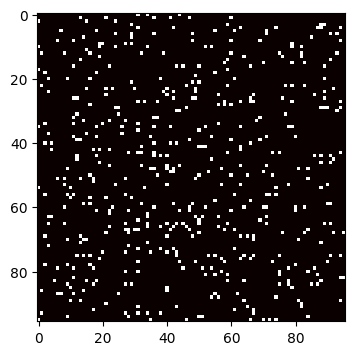

In [210]:
a2 = random_choose_candidate_2(96,96,500)
a2[a2>0] = 1
show_matrix(a2)

In [272]:
# greedy on the distrance matrix
jobs_idx = np.array(range(jobs.shape[0]))
# randomly choose an idx as the start point
start_idx = np.random.choice(jobs_idx)
# remove the start_idx from the jobs_idx
jobs_idx = np.delete(jobs_idx, np.where(jobs_idx == start_idx))

In [ ]:
d = D_prime[1:, 1:]

(496, 496)

In [284]:
jobs_idx = np.array(range(jobs.shape[0]))
# randomly choose an idx as the start point
start_idx = np.random.choice(jobs_idx)
# remove the start_idx from the jobs_idx
jobs_idx = np.delete(jobs_idx, np.where(jobs_idx == start_idx))
greedy_sequence = [start_idx]
while jobs_idx.shape[0] != 0:
    # find the minimum distance in the distance matrix of row start_idx
    min_idx = np.where(d[start_idx] == d[start_idx].min())[0]
    # randomly choose one of the minimum distance
    # check if the min_idx is in the jobs_idx
    min_idx = np.intersect1d(min_idx, jobs_idx)
    if min_idx.shape[0] == 0:
        rand_min_idx = np.random.choice(jobs_idx)
    else:
        rand_min_idx = np.random.choice(min_idx)
    # remove the rand_min_idx from the jobs_idx
    jobs_idx = np.delete(jobs_idx, np.where(jobs_idx == rand_min_idx))
    print(jobs_idx.shape[0])
    start_idx = rand_min_idx
    greedy_sequence.append(start_idx)
greedy_sequence = np.array(greedy_sequence)

493
492
491
490
489
488
487
486
485
484
483
482
481
480
479
478
477
476
475
474
473
472
471
470
469
468
467
466
465
464
463
462
461
460
459
458
457
456
455
454
453
452
451
450
449
448
447
446
445
444
443
442
441
440
439
438
437
436
435
434
433
432
431
430
429
428
427
426
425
424
423
422
421
420
419
418
417
416
415
414
413
412
411
410
409
408
407
406
405
404
403
402
401
400
399
398
397
396
395
394
393
392
391
390
389
388
387
386
385
384
383
382
381
380
379
378
377
376
375
374
373
372
371
370
369
368
367
366
365
364
363
362
361
360
359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
247
246
245
244


In [288]:
if greedy_sequence.shape[0] %8 != 0:
    greedy_sequence = np.pad(greedy_sequence, (0, 8-greedy_sequence.shape[0]%8), 'constant', constant_values=-1)
unoptimized_seuqnece = greedy_sequence.reshape(-1, 8)
t = calculate_T(unoptimized_seuqnece)
d = D_prime[1:, 1:]
non_optimized_distance = np.trace(np.dot(t.T, d))
# change non_optimized_distance to integer
non_optimized_distance = int(non_optimized_distance)

In [ ]:
# compare the greedy distance with the VRP distance

740

In [281]:
x = np.array([1, 1, 2, 3, 4])
y = np.array([2, 1, 4, 6])
xy, x_ind, y_ind = np.intersect1d(x, y, return_indices=True)
x_ind, y_ind

(array([0, 2, 4]), array([1, 0, 2]))

In [283]:
xy

array([1, 2, 4])